### Libraries

In [1]:
# import csv
# import os
import re
import json
import umap

import hdbscan

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate

### Load Data

In [2]:
df = pd.read_csv('Query_AI_text_clean.csv')

In [3]:
df.head(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,entities,clean_text
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,True,['Midjourney'],"['Shawn Shan', 'Shawn Shan', 'Shawn Shan', 'Be...",['Glaze' 'Nightshade' 'MIT Technology Review' ...,"['Amy Nordrum', 'Nightshade', 'Google DeepMind...",innovator year shawn shan build tool help arti...
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,True,['Midjourney' 'LA' 'Netherlands'],['Josh Kahn'],['a16z' 'Ubisoft' 'ChatGPT' 'ChatGPT' 'AI' 'AI...,"['the US National Security Agency', 'Google De...",impact video game development impact video gam...
2,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",True,['Netherlands' 'Tech United' 'UK'],"['René van de Molengraft', 'Van de Molengraft'...",['Eindhoven University of Technology' 'RoboCup...,"['Google DeepMind', 'Amazon Robotics', 'Van de...",useful robot need lazy useful robot need lazy ...


### Temperature

In [4]:
min_year = df['year'].min(); max_year = df['year'].max() # Find min and max
mid_year = (max_year + min_year) // 2 # Calculate the middle year
df['temperature'] = df['year'].apply(lambda x: x - mid_year) # Apply the transformation

# Function to interpolate between red (#FF0000) and blue (#0000FF)
def year_to_color(year, min_year, max_year):
    norm = (year - min_year) / (max_year - min_year)  # Normalize between 0 and 1
    return mcolors.to_hex((1-norm, 0, norm))  # Interpolate between red (1, 0, 0) and blue (0, 0, 1)

# Apply the color function based on the year
df['color'] = df['year'].apply(lambda x: year_to_color(x, min_year, max_year))


df.sample(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,entities,clean_text,temperature,color
345,fde1417f843b6b2def6722bbc70f00f1621b2b043ebe57...,2024-02-25 03:51:35.577552,en,technologyreview.com,technologyreview.com,2023-07-05,Eric Schmidt: This is how AI will transform ho...,https://www.technologyreview.com/2023/07/05/10...,2023,Eric Schmidt: This is how AI will transform th...,True,[],"['Eric Schmidt', 'Minkyung Baek', 'David Baker...",['Google' 'Nvidia' 'Earth-2' 'AI' 'AI' 'MIT'\n...,"['MIT', 'Google DeepMind', 'Stuart Russell', '...",eric schmidt transform science get eric schmid...,1,#5500aa
418,dfec35221200251f33b43ee4cf3847522ce01793b76c14...,2024-03-07 19:12:40.510937,en,technologyreview.com,technologyreview.com,2023-02-24,AI image generator Midjourney blocks porn by b...,https://www.technologyreview.com/2023/02/24/10...,2023,AI image generator Midjourney blocks porn by b...,True,['Midjourney' 'Midjourney'],"['David Holz', 'Julia Rockwell', 'Madeline Kee...",['Midjourney' 'MIT Technology Review' 'Midjour...,"['Midjourney', 'MIT', 'Madeline Keenen', 'Goog...",image generator midjourney block porn ban word...,1,#5500aa
234,cfd295b3865db2375fce6740a0ef659651ec5f0bf9b014...,2024-02-16 14:31:42.039738,en,technologyreview.com,technologyreview.com,2023-11-17,Text-to-image AI models can be tricked into ge...,https://www.technologyreview.com/2023/11/17/10...,2023,Text-to-image AI models can be tricked into ge...,True,['Israel'],"['Zico Kolter', 'Yinzhi Cao', 'Neil Zhenqiang ...",['Stability AI’s Stable Diffusion' 'Carnegie M...,"['Johns Hopkins University', 'Alex Polyakov', ...",text image model trick generate disturb image ...,1,#5500aa


In [5]:
df.columns

Index(['id', 'indexed_date', 'language', 'media_name', 'media_url',
       'publish_date', 'title', 'url', 'year', 'text', 'text_downloaded',
       'GPE', 'IND', 'ORG', 'entities', 'clean_text', 'temperature', 'color'],
      dtype='object')

### Term Frequency

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

vectorizer = CountVectorizer(
    lowercase=False,
    tokenizer=lambda key: key,  # Use if 'entities' is a list of lists
    token_pattern=None  # Disable token_pattern since we are using a custom tokenizer
)

# Convert 'entities' column (which is a list of lists) to a list
entities = df["clean_text"].to_list()

# Vectorize the list of entities
X = vectorizer.fit_transform(entities)

# Apply TF-IDF transformation
tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)

In [8]:
df.head(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,entities,clean_text,temperature,color
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,True,['Midjourney'],"['Shawn Shan', 'Shawn Shan', 'Shawn Shan', 'Be...",['Glaze' 'Nightshade' 'MIT Technology Review' ...,"['Amy Nordrum', 'Nightshade', 'Google DeepMind...",innovator year shawn shan build tool help arti...,2,#0000ff
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,True,['Midjourney' 'LA' 'Netherlands'],['Josh Kahn'],['a16z' 'Ubisoft' 'ChatGPT' 'ChatGPT' 'AI' 'AI...,"['the US National Security Agency', 'Google De...",impact video game development impact video gam...,2,#0000ff
2,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",True,['Netherlands' 'Tech United' 'UK'],"['René van de Molengraft', 'Van de Molengraft'...",['Eindhoven University of Technology' 'RoboCup...,"['Google DeepMind', 'Amazon Robotics', 'Van de...",useful robot need lazy useful robot need lazy ...,2,#0000ff


## UMAP

c:\Users\UserAlba\anaconda3\envs\visual_studio_code\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\UserAlba\anaconda3\envs\visual_studio_code\Lib\site-packages\pointgrid\pointgrid.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '557.1428571428575' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[site, ['y', 'x']] = [x,y]
c:\Users\UserAlba\anaconda3\envs\visual_studio_code\Lib\site-packages\pointgrid\pointgrid.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '504.6883116883115' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.

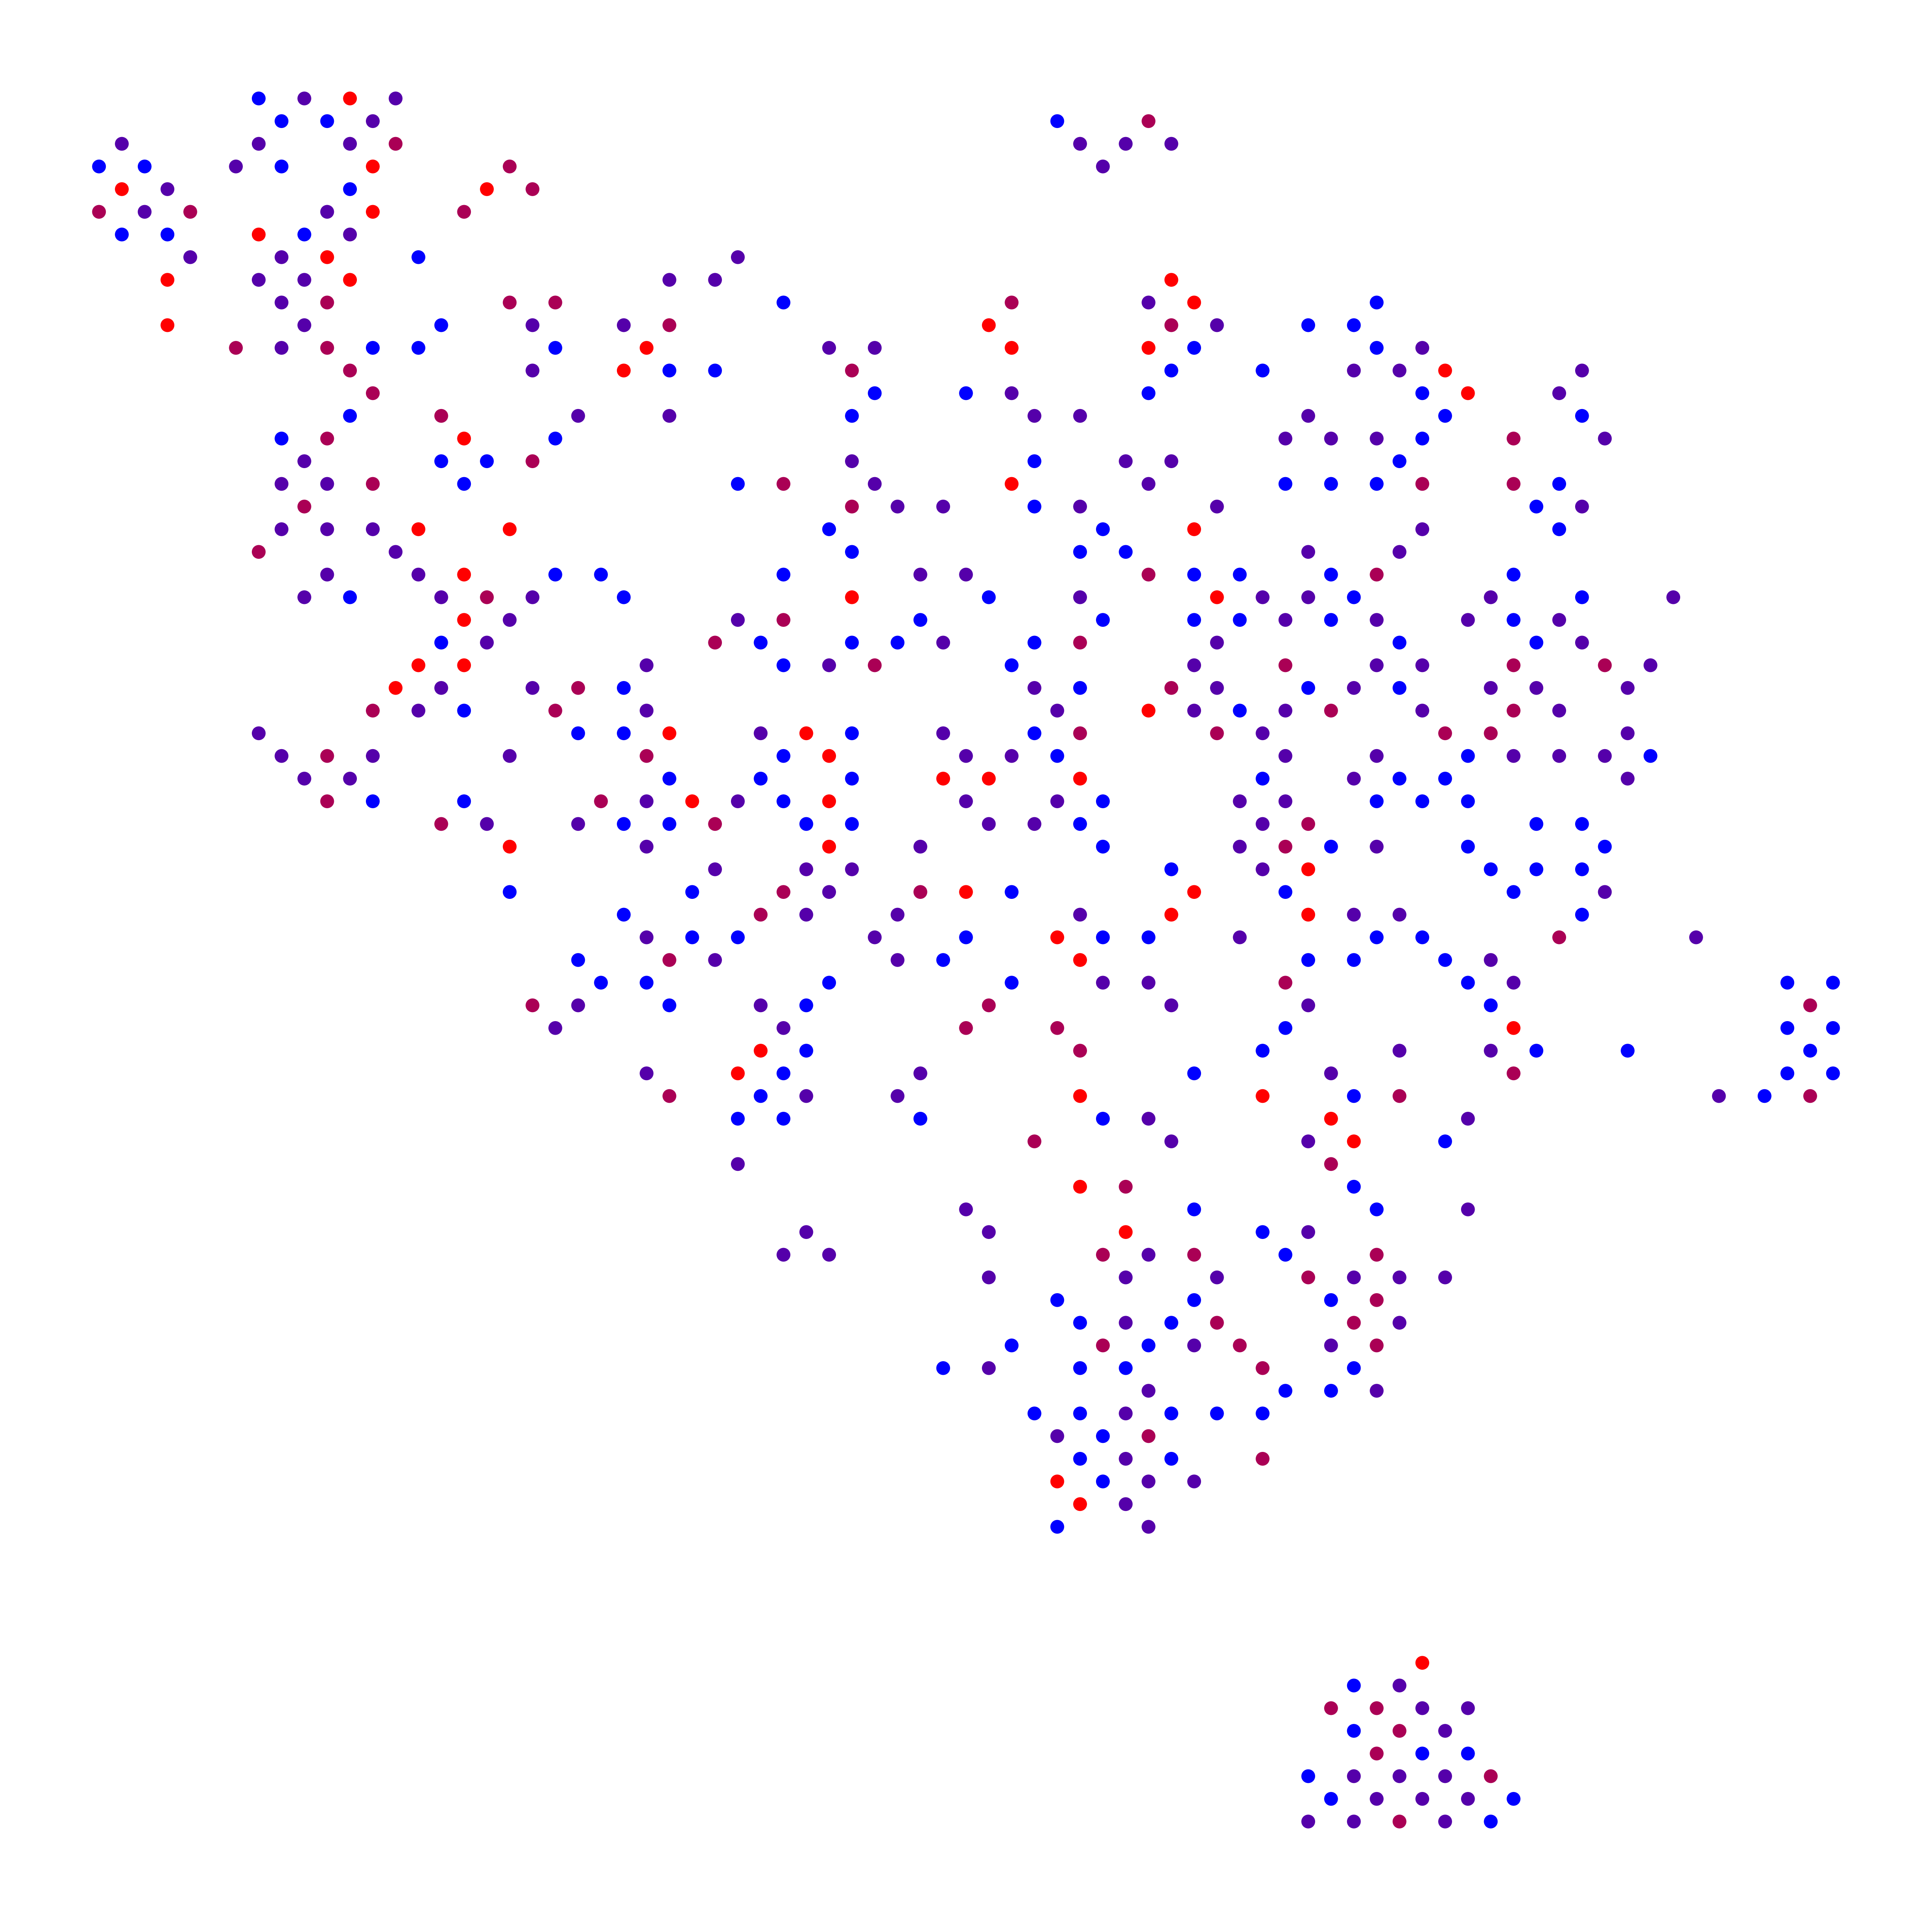

In [9]:
# Fit UMAP reducer without random_state for parallelism
reducer = umap.UMAP(
    random_state=1,
    n_components=2,
    n_neighbors=10,
    min_dist=0.1,
    metric="hellinger"
)

embedding = reducer.fit_transform(train_data) # run UMAP



scaler = MinMaxScaler(feature_range=(100, 900)) # Scale embeddings to a fixed range (100 to 900)
embedding_scaled = scaler.fit_transform(embedding)
embedding_scaled = embedding_scaled.astype(int)

embedding_scaled = align_points_to_grid(embedding_scaled)  # Alignment to a grid

# Assign embeddings (x, y) back to 'entities' DataFrame
index_embedding = 0

for index, row in df.iterrows():
    df.loc[index, "x"] = embedding_scaled[:, 0][index_embedding]
    df.loc[index, "y"] = embedding_scaled[:, 1][index_embedding]
    index_embedding += 1

# Plotting
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot with size based on 'frequency' and color from 'color'
plt.scatter(
    df["x"].to_list(),
    df["y"].to_list(),
    s=50,
    c=df["color"].to_list(),
)

# Labels
# for i, row in df.iterrows():
#     text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
#     text.set_fontsize(3)  # Adjust if too small

# Save the plot
plt.savefig("download.png")


In [10]:
df.head(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,entities,clean_text,temperature,color,x,y
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,True,['Midjourney'],"['Shawn Shan', 'Shawn Shan', 'Shawn Shan', 'Be...",['Glaze' 'Nightshade' 'MIT Technology Review' ...,"['Amy Nordrum', 'Nightshade', 'Google DeepMind...",innovator year shawn shan build tool help arti...,2,#0000ff,649.961039,494.805195
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,True,['Midjourney' 'LA' 'Netherlands'],['Josh Kahn'],['a16z' 'Ubisoft' 'ChatGPT' 'ChatGPT' 'AI' 'AI...,"['the US National Security Agency', 'Google De...",impact video game development impact video gam...,2,#0000ff,732.974026,536.363636
2,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",True,['Netherlands' 'Tech United' 'UK'],"['René van de Molengraft', 'Van de Molengraft'...",['Eindhoven University of Technology' 'RoboCup...,"['Google DeepMind', 'Amazon Robotics', 'Van de...",useful robot need lazy useful robot need lazy ...,2,#0000ff,598.077922,775.324675


## Clustering

In [29]:
clusterer = hdbscan.HDBSCAN(
    min_samples=2,            # Aumenta el número de clusters reduciendo los puntos necesarios para un área densa
    min_cluster_size=3,       # Tamaño mínimo del cluster; si lo reduces, obtendrás más clusters
    cluster_selection_epsilon=0.4  # Controla la fusión de clusters cercanos. Reducirlo puede ayudar a obtener más clusters.
)

df["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, df):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            df.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            df.loc[index, "cluster"] = str(clusters[count])
    

cluster_computing(
    df.loc[(df["temperature"] > 0)],
    "p_",
    df,
)
cluster_computing(
    df.loc[(df["temperature"] <= 0)],
    "n_",
    df,
)

df.sample(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,...,GPE,IND,ORG,entities,clean_text,temperature,color,x,y,cluster
155,da55dce94617392991c1773f3a8aaf5326fc81bfb24034...,2024-03-28 04:11:39.396438,en,technologyreview.com,technologyreview.com,2024-03-26,AI could make better beer. Here’s how.,https://www.technologyreview.com/2024/03/26/10...,2024,AI could make better beer. Here’s how.\nAI mod...,...,[],"['Kevin Verstrepen', 'Carolyn Ross']",['AI' 'Nature Communications' 'KU Leuven'\n 'V...,"['Synthesia', 'Meta', 'MIT Technology Review',...",well beer well beer model well human expert pr...,2,#0000ff,681.090909,796.103896,p_16
315,9eee5bdbc202ff2a325a1978d2f0989f2810055f77fee7...,2024-02-23 00:23:31.452019,en,technologyreview.com,technologyreview.com,2023-08-14,"The Download: corporate presentations, and car...",https://www.technologyreview.com/2023/08/14/10...,2023,"This is today's edition of The Download, our w...",...,['US' 'Kleberg County' 'Texas' 'Louisiana' 'Sa...,"['Claire L. Evans', 'James Temple\nAI', 'Tate ...",['Next' 'PowerPoint' 'Microsoft' 'PowerPoint' ...,"['Diane Morgan', 'Alabama', 'Technocrat', '💊',...",download corporate presentation carbon removal...,1,#5500aa,535.818182,276.623377,p_15
56,fdec091233661ec192c68a0f295b3280baee4386bb9fec...,2024-07-18 15:25:04.164166,en,technologyreview.com,technologyreview.com,2024-07-18,What’s next for SpaceX’s Falcon 9,https://www.technologyreview.com/2024/07/18/10...,2024,What’s next for SpaceX’s Falcon 9\nAn engine m...,...,['US' 'US' 'US' 'California' 'US' 'US' 'US' 'J...,"['Jonathan McDowell', 'Paulo Lozano', 'Jacob I...",['SpaceX' 'Falcon 9' 'MIT Technology Review' '...,"['MIT', 'Google DeepMind', 'Jacob Isaacman', '...",spacex falcon spacex falcon engine malfunction...,2,#0000ff,432.051948,692.207792,p_22


{'n_2', 'p_14', 'p_26', 'n_8', 'p_1', 'p_11', 'n_5', 'p_6', 'n_18', 'p_29', 'p_22', 'p_4', 'p_21', 'p_28', 'p_27', 'p_5', 'p_0', 'n_15', 'n_16', 'p_17', 'n_3', 'n_1', 'p_19', 'n_7', 'p_9', 'n_0', 'n_12', 'n_9', 'p_24', 'p_16', 'p_33', 'p_23', 'p_31', 'n_11', 'p_8', 'p_13', 'p_3', 'n_10', 'n_14', '-1', 'p_32', 'p_18', 'n_17', 'p_25', 'n_6', 'p_10', 'p_2', 'p_20', 'n_4', 'p_15', 'p_12', 'p_30', 'p_7', 'n_13'}


QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 681419264  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 31  Error-roundoff 6.7e-13  _one-merge 3.4e-12
  _near-inside 1.7e-11  Visible-distance 1.3e-12  U-max-coplanar 1.3e-12
  Width-outside 2.7e-12  _wide-facet 8.1e-12  _maxoutside 4e-12

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p0(v3): 6e+02 7.8e+02
- p3(v2): 6.1e+02 7.9e+02
- p1(v1): 5.8e+02 7.5e+02

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 6.7e-13.  The center point, facets and distances
to the center point are as follows:

center point    594.6    771.9

facet p3 p1 distance= -1.1e-13
facet p0 p1 distance= 1.1e-13
facet p0 p3 distance= 1.1e-13

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:     577.3     608.5  difference= 31.13
  1:     754.5     785.7  difference= 31.17

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 6.7e-13.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


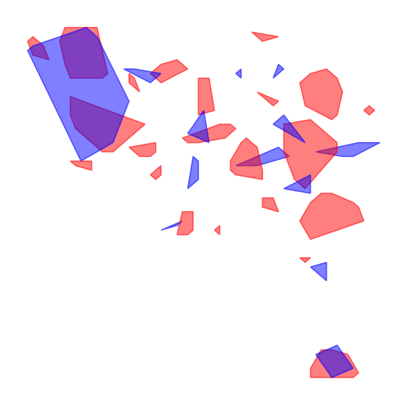

In [30]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(df["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = df.loc[df["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    if len(points) < 3:
        print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#FF0000", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#0000FF", alpha=0.5)  # Plot blue


# Save

In [76]:
export = df.copy()

# export = export.drop(columns="entities")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)


,title,url,year,entities,temperature,color,x,y,cluster
1704,How AI could solve supply chain shortages and ...,https://www.technologyreview.com/2021/10/26/10...,2021,"[DHL, Amazon, Ford, Gemini, AI, University Col...",-1,#ff0000,255.844156,806.493506,n_0
